# Retrieval methods

## Rag Fusion

![Retrieval diagram](../data/images/image_retrival.png)


In [1]:
# === 0. Imports & env ===
from pathlib import Path
import os, json
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()                                 #  ← loads ~/.env AND .env in CWD

OPENAI_KEY = os.getenv("OPENAI_API_KEY")

# === 1. LLM & embeddings ===
llm        = ChatOpenAI(model_name="gpt-4o", temperature=0.2, openai_api_key=OPENAI_KEY)
embeddings = OpenAIEmbeddings(openai_api_key=OPENAI_KEY)
parser     = StrOutputParser()

# === 2. Re‑attach to the existing Chroma collection ===
CHROMA_DIR = Path("/Users/pantost/Desktop/codehub/rag-virtual-assistant-course/chroma_store")
           #  ← same dir you use in main.py
vectorstore = Chroma(
    embedding_function = embeddings,
    persist_directory = str(CHROMA_DIR),
    collection_name   = "your_collection_name",
)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})  # grab a few more docs

# === 3. Multi‑query rewrite chain (same logic as _rewrite in main.py) ===
rewrite_prompt = ChatPromptTemplate.from_messages([
    ("system",
     "Rewrite the user query in three *different* ways that could improve "
     "vector search recall. One per line, no bullets."),
    ("human", "Original: {question}\nRewrites:")
])
rewrite_chain = rewrite_prompt | llm | StrOutputParser()

def generate_queries(question: str) -> list[str]:
    """Return [original, rewrite1, rewrite2, rewrite3]."""
    raw = rewrite_chain.invoke({"question": question})
    rewrites = [ln.strip() for ln in raw.splitlines() if ln.strip()]
    return [question] + rewrites

# === 4. Reciprocal‑Rank‑Fusion helper ===
def rrf(ranked_lists: list[list], k: int = 60):
    """Fuse multiple ranked doc‑lists with RRF; return list[(doc, score)]."""
    scores = {}
    for docs in ranked_lists:
        for rank, doc in enumerate(docs):
            key = doc.page_content            # simple, content‑based key
            scores[key] = scores.get(key, 0) + 1 / (rank + k)
    # recover doc objects from the first list that contains them
    doc_map = {doc.page_content: doc for docs in ranked_lists for doc in docs}
    fused = [(doc_map[c], s) for c, s in sorted(scores.items(), key=lambda x: x[1], reverse=True)]
    return fused

# === 5. Ask a question ===
question = ("what does the imf say about greek recovery?")

# --- 5a Generate queries
queries = generate_queries(question)

print(f"Original query: {question} \n")

print("🔍 Queries:", *queries, sep="\n  • ")

# --- 5b Retrieve docs per query
retrievals = [retriever.invoke(q) for q in queries]

# --- 5c Fuse & show top‑N
fused_docs = rrf(retrievals, k=60)
print(f"\n📚 Top {min(5,len(fused_docs))} RRF‑ranked docs:")
for i, (d, score) in enumerate(fused_docs[:5], 1):
    preview = d.page_content[:300].replace("\n", " ")
    print(f"{i}. (score={score:.3f}) {preview}…\n")

# === 6. Final answer generation, grounded in top fused docs ===
GEN_PROMPT = ChatPromptTemplate.from_template(
    "Answer using ONLY the context below. If the context is insufficient, say "
    "\"I don't know\".\n\nContext:\n{context}\n\nQuestion: {question}\nAnswer:"
)
gen_chain = GEN_PROMPT | llm | StrOutputParser()

context = "\n\n".join(doc.page_content for doc, _ in fused_docs[:3])  # use top‑3 docs
answer = gen_chain.invoke({"context": context, "question": question})

print("\n🎯 Final Answer:\n", answer)


Original query: what does the imf say about greek recovery? 

🔍 Queries:
  • what does the imf say about greek recovery?
  • What are the International Monetary Fund's views on Greece's economic recovery?
  • How does the IMF assess the progress of Greece's recovery?
  • What is the IMF's opinion on the recovery of the Greek economy?

📚 Top 5 RRF‑ranked docs:
1. (score=0.066) GREECE  INTERNATIONAL MONETARY FUND 21  Figure 1. Greece: Recent Developments—Robust Growth  The economy has continued to grow at a robust pace  on the back of strong investment and private  consumption.   On the production side, recent growth has been driven  by manufacturing sectors as well as the…

2. (score=0.065) GREECE  4 INTERNATIONAL MONETARY FUND  CONTEXT: HEALING PROCESS WELL UNDERWAY  1.      The Greek economy has sustained its robust expansion while further enhancing its  fiscal and financial health. Since 2021, the economy has experienced cumulative growth of   20 percent—with real GDP per capita at …

In [2]:
print("Total chunks in collection:", vectorstore._collection.count())


Total chunks in collection: 275


## Re-Ranker

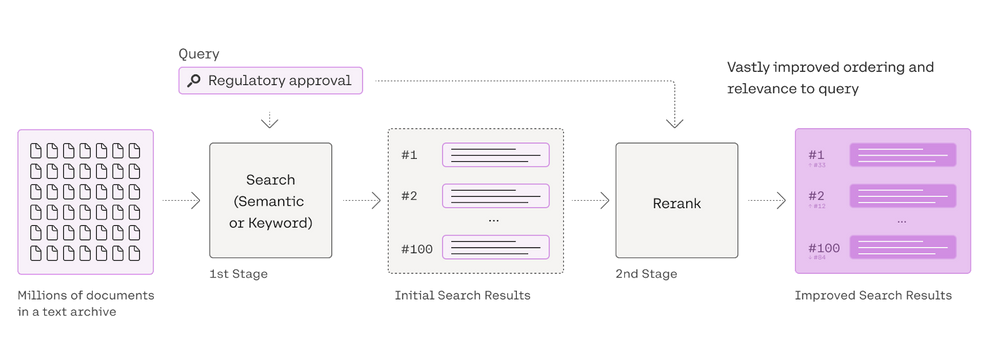

In [3]:
# ---------------- Reranker setup ----------------
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, torch.nn.functional as F

reranker_name = "BAAI/bge-reranker-large"
tokenizer = AutoTokenizer.from_pretrained(reranker_name)
model = AutoModelForSequenceClassification.from_pretrained(reranker_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

# ---------------- Prepare unique docs ----------------
unique_docs, seen = [], set()
for docs in retrievals:
    for d in docs:
        if d.page_content not in seen:
            seen.add(d.page_content)
            unique_docs.append(d)

print(f"🔎 {len(unique_docs)} unique docs to rerank")

# ---------------- Batch‑score with the reranker ----------------
scores = []
batch_size = 8
for start in range(0, len(unique_docs), batch_size):
    batch_pairs = unique_docs[start : start + batch_size]
    enc = tokenizer(
        [question] * len(batch_pairs),                    # queries
        [doc.page_content[:512] for doc in batch_pairs],  # docs (truncated)
        padding=True, truncation=True, max_length=512, return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**enc).logits.squeeze(-1)          # shape (batch,)
        scores.extend(logits.cpu().tolist())

# Zip docs with scores and sort
scored_docs = sorted(zip(unique_docs, scores), key=lambda x: x[1], reverse=True)

# ---------------- Show top‑N reranked docs ----------------
top_n = 5
print(f"\n🏅 Top {top_n} docs (reranked by bge‑reranker‑large):")
for i, (doc, score) in enumerate(scored_docs[:top_n], 1):
    prev = doc.page_content[:300].replace("\n", " ")
    print(f"{i}. (score: {score:.3f}) {prev}…\n")

# ---------------- Final answer generation from reranked docs ----------------
top_context = "\n\n".join(doc.page_content for doc, _ in scored_docs[:3])
answer_rerank = gen_chain.invoke({"context": top_context, "question": question})

print("🎯 Final Answer (Reranker):\n", answer_rerank)


🔎 7 unique docs to rerank

🏅 Top 5 docs (reranked by bge‑reranker‑large):
1. (score: 1.432) GREECE  4 INTERNATIONAL MONETARY FUND  CONTEXT: HEALING PROCESS WELL UNDERWAY  1.      The Greek economy has sustained its robust expansion while further enhancing its  fiscal and financial health. Since 2021, the economy has experienced cumulative growth of   20 percent—with real GDP per capita at …

2. (score: -1.437) GREECE  INTERNATIONAL MONETARY FUND 19  STAFF APPRAISAL  34.      Greece's near-term economic outlook remains favorable. Real GDP has continued its  robust expansion, driven by public investment and structural reforms in the context of the NGEU  funding, alongside steady growth of private consumptio…

3. (score: -1.850) GREECE  INTERNATIONAL MONETARY FUND 21  Figure 1. Greece: Recent Developments—Robust Growth  The economy has continued to grow at a robust pace  on the back of strong investment and private  consumption.   On the production side, recent growth has been driven  by 

# Simple reranker

In [4]:
from sentence_transformers import CrossEncoder
from langchain.schema import Document

# 2. Load the cross-encoder reranker
reranker = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# 3. Format input pairs: (question, doc) for each document
pairs = [(question, doc.page_content) for doc in unique_docs]

# 4. Run scoring (no torch code needed)
scores = reranker.predict(pairs)

# 5. Zip documents with scores and sort
scored_docs = sorted(zip(unique_docs, scores), key=lambda x: x[1], reverse=True)

# 6. Print top reranked docs
print("\n🏅 Top 5 docs (MiniLM reranker via sentence-transformers):")
for i, (doc, score) in enumerate(scored_docs[:5], 1):
    print(f"{i}. (score: {score:.3f}) {doc.page_content[:300].replace(chr(10), ' ')} …\n")

# 7. Use top 3 docs for final generation
top_context = "\n\n".join(doc.page_content for doc, _ in scored_docs[:3])
answer_reranked = gen_chain.invoke({"context": top_context, "question": question})
print("🎯 Final Answer (MiniLM reranker):\n", answer_reranked)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



🏅 Top 5 docs (MiniLM reranker via sentence-transformers):
1. (score: 1.635) GREECE  INTERNATIONAL MONETARY FUND 21  Figure 1. Greece: Recent Developments—Robust Growth  The economy has continued to grow at a robust pace  on the back of strong investment and private  consumption.   On the production side, recent growth has been driven  by manufacturing sectors as well as the …

2. (score: 0.281) GREECE  4 INTERNATIONAL MONETARY FUND  CONTEXT: HEALING PROCESS WELL UNDERWAY  1.      The Greek economy has sustained its robust expansion while further enhancing its  fiscal and financial health. Since 2021, the economy has experienced cumulative growth of   20 percent—with real GDP per capita at  …

3. (score: -0.004) PR25/89    IMF Executive Board Concludes 2025 Article IV Consultation  with Greece  FOR IMMEDIATE RELEASE    Washington, DC – April 7, 2025: The Executive Board of the International Monetary Fund  (IMF) concluded the Article IV consultation1 with Greece on March 31, 2025.  Gree